# Does adverserial training work?

In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    # Tell the virtualized kernel where to load my libraries
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    # Running locally
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Connected to a GPU


This is my trick for reloading the backend library from the google drive without needing to restart the kernel. Re-evaluate this cell if you change util.py

In [0]:
import importlib
import util
importlib.reload(util)
from util import *

This training loop does adverserial training. Here, only deterministic functions are considered, so that the notion of expected value of a distribution $\mathbb{E}_y[]$ merges into the sum over the batch. The general loss function with which to optimize $f$ has two components:
\begin{equation}
L(x,y) = \lambda_1\left\| y - f(x) \right\| + \lambda_2\left( 1 - D(f(x)|x) + D(y|x) \right)
\end{equation}
When $\lambda_2\neq0$, the discriminator is trained in the game with its own loss function,
\begin{equation}
L_D(x,y) = - \left( 1-D(f(x)|x) + D(y|x)  \right)
\end{equation}
Let us compare the difference between training on only the mean-squared error, the discriminator, and a combination of the two. We posit that being able to derive the expected stencil using purely adverserial training with the discriminator-based loss function would be a validation to the notion of generative advedrserial training for physics problems.

In [0]:
loss_L2 = torch.nn.MSELoss()
def train_it(dataset, model, disc,
             use_L2=False, use_disc=True,
             learning_rate = 1e-1, batch_size=20, print_param=False,
             Npast=1, Nfuture=1):
    """
    Training loop for a given dataset, pre-initialized model, and pre-
    initialized discriminator. The training loop is set up for advserial 
    training and/or L2 training, but will only optimize the discriminator if it 
    is needed.

    print_param shows the value of the first layer, which is intended to show 
    the convergence to the FDM stencil.
    """
    optim_model = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optim_disc  = torch.optim.Adam(disc.parameters(), lr=learning_rate)

    Nepoch = 1000
    Nbatch = 50
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,3))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        # Do one step
        y_pred = model(xx)+xx
        # Step the discriminator
        if use_disc:
            #L_D = -0.5*(1.0 - disc(y_pred,xx).mean() + disc(yy,xx).mean())
            # I was afraid of round-error; the location of this maximum is the same.
            # The results did not change; this does change the relative scaling
            # between the discriminator loss and the MSE loss.
            L_D =  disc(y_pred,xx).sum() - disc(yy,xx).sum()
            optim_disc.zero_grad()
            L_D.backward(retain_graph=True)
            optim_disc.step()
        else:
            L_D = torch.tensor(0)

        # Step the model
        if use_disc and not use_L2:
            L_G = - disc(y_pred,xx).sum()
        if use_L2 and not use_disc:
            L_G = loss_L2(y_pred,yy)
        if use_L2 and use_disc:
            L_G = - disc(y_pred,xx).sum() + loss_L2(y_pred,yy)
        optim_model.zero_grad()
        L_G.backward()
        optim_model.step()
        
        #yy[:,:,1:-1]
        
        if e%Nprint == Nprint-1:
            L2 = loss_L2(y_pred,yy)
            print(e, L_D.item(),L2.item(), end='')
            if print_param:
                print( list(model.parameters())[0].cpu().detach().numpy(),end='' )
            print()
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss_L2(yyt,yt_pred)
            L2 = loss_L2(y_pred,yy)
            losses[e//Nsave,0] = L_D.item()
            losses[e//Nsave,1] = L2.item()
            losses[e//Nsave,2] = test_err.item()
    return losses

This experiment is only run with the heat equation and the well-known 3-point stencil.

In [0]:
models = {"PureStencil":PureStencil,}
dataname = "heat"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

This is a poor-man's database that has zero requirements to help with reproducibility. We just save all of the training stats and the models themselves in the same pickle.

In [0]:
#stash = {}
with open(root+f"/gan_data_{dataname}.pkl","rb") as f:
    stash = torch.load(f)

To verify/unverify robustness, each combiniation is run 5 times.

In [8]:
for name, cls in models.items():
    for use_L2,use_disc in [ (True, False), (False,True), (True,True)]:
        for i in range(5):
            key = f"{name}_{use_L2}_{use_disc}_{i}"
            try:
                entry = stash[key]
                print("Resuming training of ",key)
            except KeyError:
                entry = {"model":cls(Nx).to(device),
                        "disc":ConditionalDiscriminatorConv(Nx,1).to(device),
                        "results":np.empty((0,3))}
                print("Training new ",key)
            model,disc,results = entry['model'],entry['disc'],entry['results']
            tr_res = train_it(dataset,model,disc, learning_rate=1.0e-2, 
                            use_L2 = use_L2, use_disc=use_disc,
                            print_param=True)
            results = np.append(results, tr_res, axis=0)
            stash[key] = {'model':model,
                        'disc':disc,
                        'results':results}
with open(root+f"/gan_data_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

Resuming training of  PureStencil_True_False_0
1939 0 3.645725854539705e-08[[[ 0.3990234  -0.79823095  0.3990683 ]]]
3879 0 2.7881657871375864e-08[[[ 0.3992825  -0.79806674  0.39932537]]]
5819 0 3.4633853829291184e-07[[[ 0.3988067  -0.79890627  0.39883685]]]
7759 0 1.7110242112039487e-09[[[ 0.39921516 -0.7984999   0.39924073]]]
9699 0 2.6019911225638737e-10[[[ 0.39929387 -0.79869735  0.3993499 ]]]
11639 0 8.271497335954336e-07[[[ 0.39893553 -0.7976715   0.3989809 ]]]
13579 0 2.62970645259486e-10[[[ 0.3990468  -0.79830456  0.39907905]]]
15519 0 4.82654860523013e-10[[[ 0.39943475 -0.7990191   0.3995007 ]]]
17459 0 4.455935354030771e-08[[[ 0.39894813 -0.7975557   0.39899206]]]
19399 0 2.441447861656343e-07[[[ 0.39873663 -0.798197    0.39877364]]]
Resuming training of  PureStencil_True_False_1
1939 0 3.596836384289759e-09[[[ 0.39927796 -0.79914075  0.3993125 ]]]
3879 0 3.6575670492311474e-08[[[ 0.39929846 -0.79898983  0.3993376 ]]]
5819 0 4.0209719998074434e-08[[[ 0.3994495  -0.7985015   0

This sorts the results for making the paper-ready documents:

In [0]:
get_params = lambda x : list(x.parameters())[0].cpu().detach().numpy()
colmdict = {"True_False":[],"False_True":[],"True_True":[]}
for N,S in stash.items():
    colmdict[N[12:-2]].append(S)
    #print(N," : ", get_params(S['model'])/alpha )

The training and testing loss throughout training is plotted here to see how they performmed on those basic metrics: 

Game


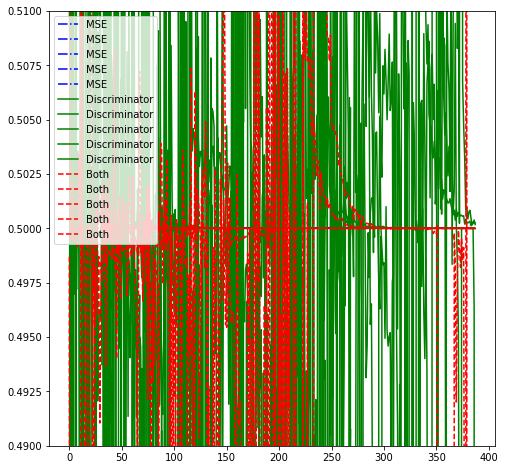

L2 Loss


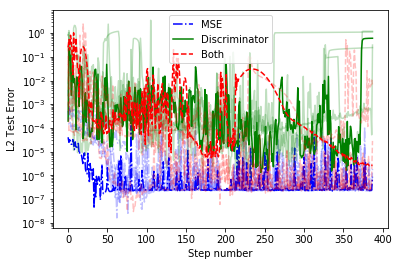

In [72]:
plt.figure(figsize=(6,4))
colordict = {"True_True":'r--',"True_False":'b-.',"False_True":'g-'}
labeldict = {"True_True":'Both',"True_False":'MSE',"False_True":'Discriminator'}
print("Game")
for N,S in stash.items():
    plt.plot(0.5+0.5*S['results'][:,0],colordict[N[12:-2]],label=f"{labeldict[N[12:-2]]}")
plt.ylim((0.49,0.51))
plt.legend()
#plt.title('Game')
plt.show()
print("L2 Loss")
plt.figure(figsize=(6,4))
for N,colm in colmdict.items():
    alpha_channel = 1
    label = labeldict[N]
    for S in colm:
        #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
        plt.semilogy(S['results'][:,2],colordict[N],label=label,alpha=alpha_channel)
        alpha_channel = 0.25
        label = None
plt.legend()
plt.xlabel('Step number')
plt.ylabel('L2 Test Error')
plt.savefig(root+'/paper/3pt_L2_loss.png',dpi=300)
plt.show()

In [0]:
Dt,Dx = 0.25/100 , 1.0/40
alpha = 0.1*Dt/(Dx**2)

I copy an pasted this into the paper:

In [60]:
import tabulate
tabledict = {}
for N in colmdict:
    tabledict[N] = np.array([ get_params(c['model']).flatten()/alpha for c in colmdict[N]])
tabl = np.hstack([tabledict[N] for N in tabledict])
string = tabulate.tabulate(tabl,tablefmt='latex',floatfmt='1.3f')
print(string)

\begin{tabular}{rrrrrrrrr}
\hline
 0.997 & -1.995 & 0.997 & 1.398 & -1.149 & 1.401 & 1.073 & -2.149 & 1.077 \\
 0.997 & -1.995 & 0.998 & 1.058 & -3.196 & 0.956 & 0.994 & -2.000 & 0.995 \\
 0.998 & -1.996 & 0.998 & 1.512 & -0.824 & 1.624 & 0.595 & -1.502 & 0.732 \\
 0.998 & -1.994 & 0.999 & 1.084 & -1.154 & 1.116 & 1.000 & -2.001 & 1.000 \\
 0.998 & -1.995 & 0.998 & 1.392 & -0.558 & 1.394 & 1.000 & -1.999 & 1.000 \\
\hline
\end{tabular}


The general purpose test is to see how they perform on recurrent integration on the validation trajectories which they were never shown during training; however, we already know what the stencil was *supposed* to be, so this is a bit of a moot point.

PureStencil_True_False_0


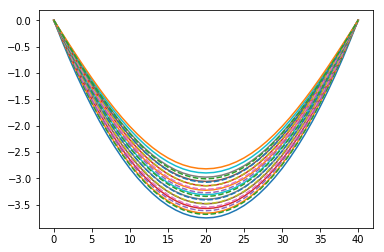

PureStencil_True_False_1


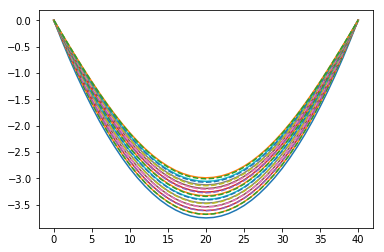

PureStencil_True_False_2


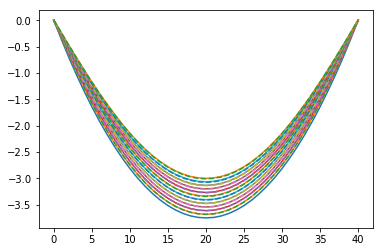

PureStencil_True_False_3


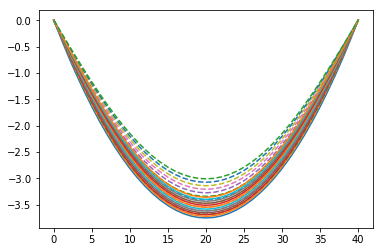

PureStencil_True_False_4


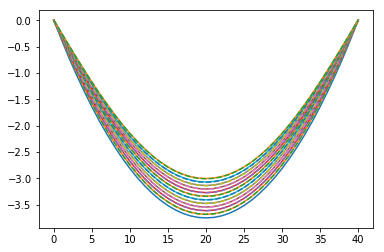

PureStencil_False_True_0


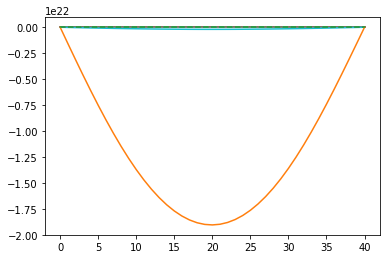

PureStencil_False_True_1


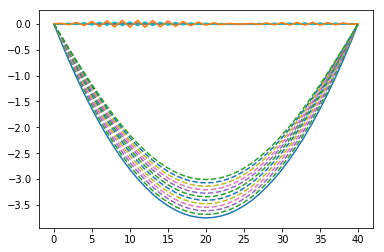

PureStencil_False_True_2


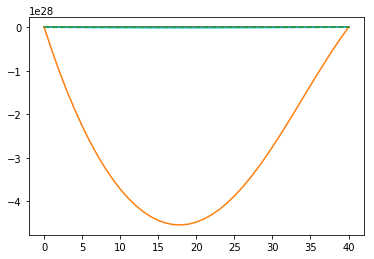

PureStencil_False_True_3


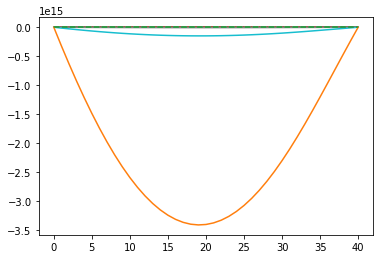

PureStencil_False_True_4


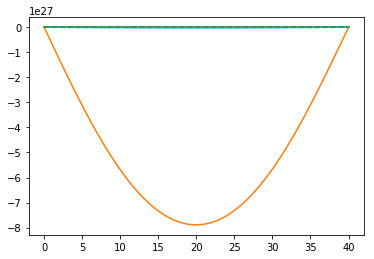

PureStencil_True_True_0


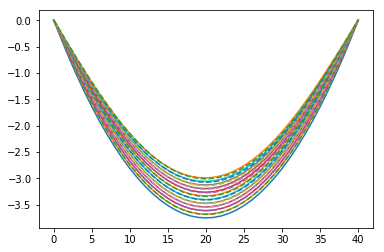

PureStencil_True_True_1


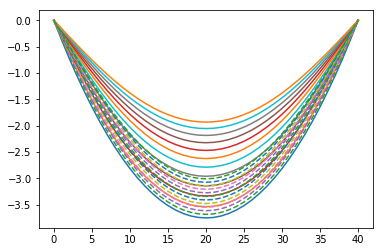

PureStencil_True_True_2


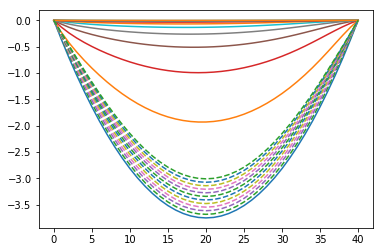

PureStencil_True_True_3


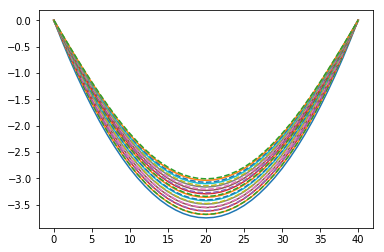

PureStencil_True_True_4


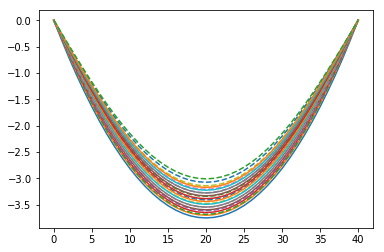

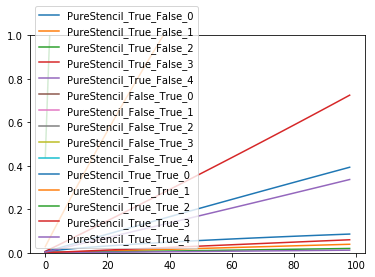

PureStencil_True_False_0


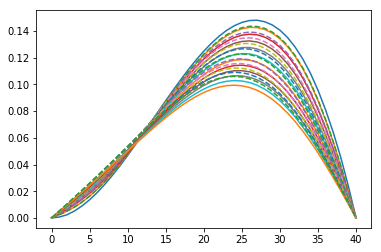

PureStencil_True_False_1


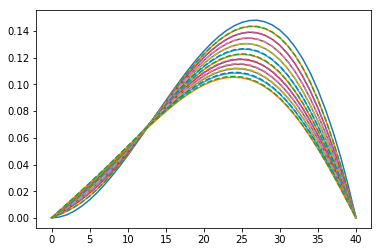

PureStencil_True_False_2


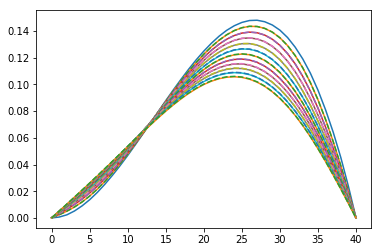

PureStencil_True_False_3


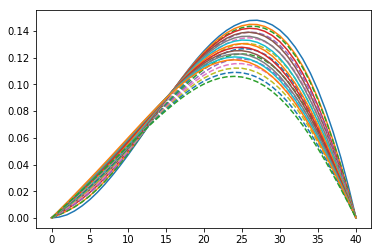

PureStencil_True_False_4


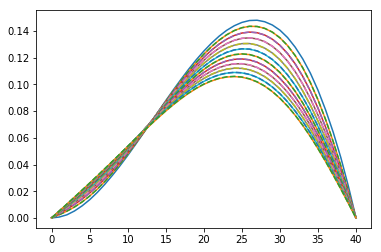

PureStencil_False_True_0


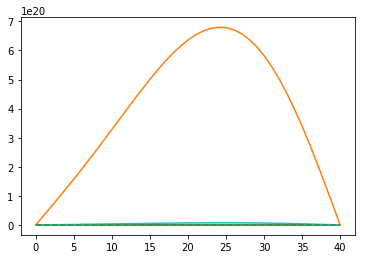

PureStencil_False_True_1


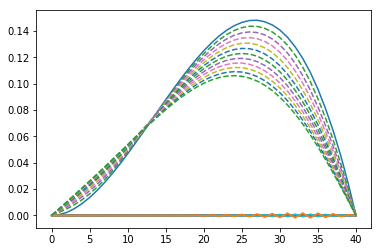

PureStencil_False_True_2


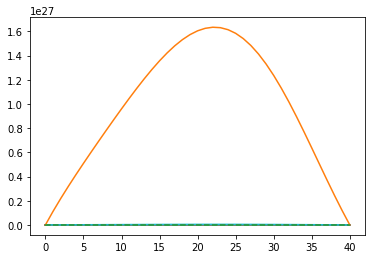

PureStencil_False_True_3


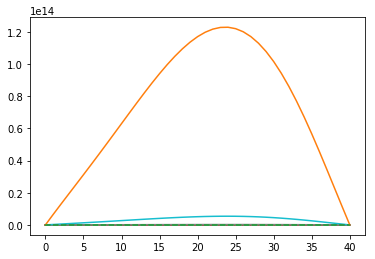

PureStencil_False_True_4


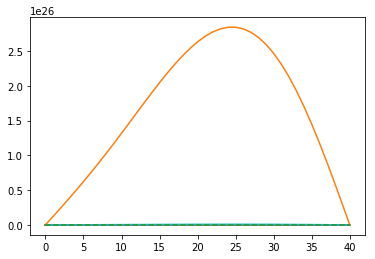

PureStencil_True_True_0


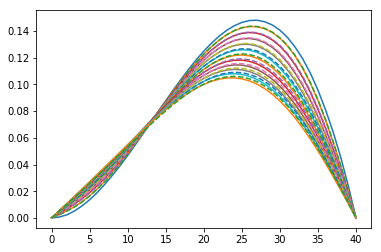

PureStencil_True_True_1


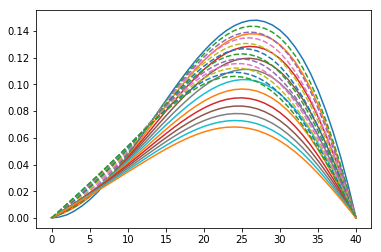

PureStencil_True_True_2


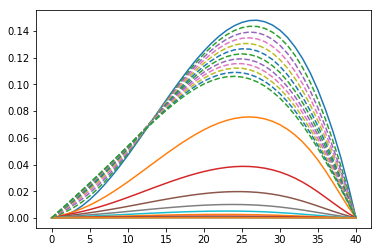

PureStencil_True_True_3


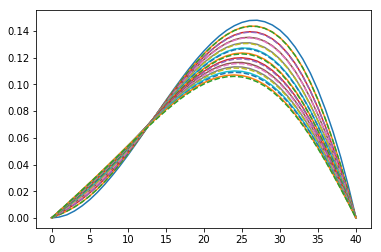

PureStencil_True_True_4


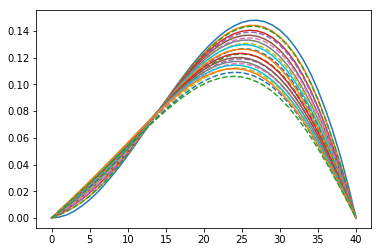

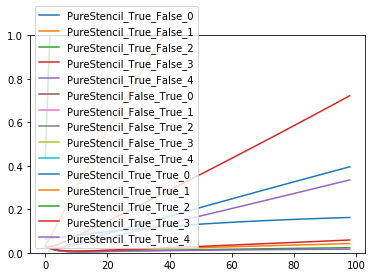

In [61]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.ylim((0,1))
    plt.legend()
    plt.show()

In [19]:
for N,S in stash.items():
    print(f"{N}: {list(S['model'].parameters())}")

PureStencil: [Parameter containing:
tensor([[[-1.4110, -1.6576, -0.9887]]], device='cuda:0', requires_grad=True)]
PureStencil_True: [Parameter containing:
tensor([[[ 0.3998, -0.8002,  0.3998]]], device='cuda:0', requires_grad=True)]
PureStencil_False: [Parameter containing:
tensor([[[ 0.5688, -1.0670,  0.5513]]], device='cuda:0', requires_grad=True)]


In [0]:
with open(root+"/gandb.pkl","wb") as f:
    torch.save(stash,f)

In [79]:
list(model.parameters())[0].cpu().detach().numpy()

array([[[-0.0161229 ,  0.0029486 , -0.10286506]]], dtype=float32)